In [0]:
from google.colab import drive
import numpy as np
from re import search
from collections import Counter
import string
from PIL import Image
import cv2
from nltk import tokenize
from torch.utils.data import Dataset
import pandas as pd
import os.path
from os import path
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

## Lemmatizer

In [0]:
"a guy snowboarding down a hill"
"a skier in a ski suit is skiing downhill near a fence"
"a skier races down the mountain"
"a slalom skier moving quickly downhill"
"competing skier going down the course leaning to make a sharp turn"

"a guy snowboard down a hill"
"a skier in a ski suit be ski downhill , near a fence "
"a skier race down a mountain "
"a slalom skier move quick downhill "
"compete skier go down a course lean to make a sharp turn"

to_be_stemmed = ("a skier in a ski suit is skiing downhill near a fence").split()

In [3]:
ps =PorterStemmer()
for w in to_be_stemmed:
    rootWord=ps.stem(w)
    print(f"Porter stemmer performed on '{w}' produces:", rootWord)


Porter stemmer performed on 'a' produces: a
Porter stemmer performed on 'skier' produces: skier
Porter stemmer performed on 'in' produces: in
Porter stemmer performed on 'a' produces: a
Porter stemmer performed on 'ski' produces: ski
Porter stemmer performed on 'suit' produces: suit
Porter stemmer performed on 'is' produces: is
Porter stemmer performed on 'skiing' produces: ski
Porter stemmer performed on 'downhill' produces: downhil
Porter stemmer performed on 'near' produces: near
Porter stemmer performed on 'a' produces: a
Porter stemmer performed on 'fence' produces: fenc


In [4]:
ls =LancasterStemmer()
for w in to_be_stemmed:
    rootWord=ls.stem(w)
    print(f"Lancaster stemmer performed on '{w}' produces:", rootWord)

Lancaster stemmer performed on 'a' produces: a
Lancaster stemmer performed on 'skier' produces: ski
Lancaster stemmer performed on 'in' produces: in
Lancaster stemmer performed on 'a' produces: a
Lancaster stemmer performed on 'ski' produces: ski
Lancaster stemmer performed on 'suit' produces: suit
Lancaster stemmer performed on 'is' produces: is
Lancaster stemmer performed on 'skiing' produces: ski
Lancaster stemmer performed on 'downhill' produces: downhil
Lancaster stemmer performed on 'near' produces: near
Lancaster stemmer performed on 'a' produces: a
Lancaster stemmer performed on 'fence' produces: fent


# COMP5623 Coursework on Image Caption Generation

Starter code.



## Text preparation 

We need to build a vocabulary.

In [5]:
# Mounted Drive if using Colab; otherwise, your local path 
drive.mount('/content/gdrive')

root = "/content/gdrive/My Drive/Flickr8k/" # <--- replace this with your root data directory
caption_dir = root + "captions/"                       # <--- replace these too
image_dir = root + "images/"                           # <---


token_file = "Flickr8k.token.txt"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


A helper function to read in our ground truth text file.

In [0]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip())
    file.close() 
    return lines

You can read all the ground truth captions (5 per image), into memory as follows:

In [0]:
lines = read_lines(caption_dir + token_file)

In [8]:
lines[:7]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .']

In [0]:
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

Extract all the words from ```lines```, and create a list of them in a variable ```words```, for example:

```words = ["a", "an", "the", "cat"... ]```

No need to worry about duplicates.


In [0]:
words = []
vocabbin = []
count = 0
for line in lines:
  words = line.lower().split()
  words.pop(0)
  for word in words:
    if not any(l in word for l in string.punctuation):
      vocabbin.append(word)

Build the vocabulary.

In [0]:
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')


In [0]:
vocab_sorted = vocabbin
vocab_sorted.sort()
w_count = 0
count = 0

for w in vocab_sorted:
  if count > 1:
    count += -1
    continue
  
  count = vocab_sorted.count(w)
  if (count > 3):
    w_count += 1
    vocab.add_word(w)


In [13]:
print(len(vocab))

3389


## Dataset and loaders for training

Keeping the same order, concatenate all the cleaned words from each caption into a string again, and add them all to a list of strings ```cleaned_captions```. Store all the image ids in a list ```image_ids```.

In [14]:
image_ids = []
for line in lines:
  words = line.lower().split()
  image_ids.append(words[0].split('.')[0])
print(len(image_ids))

words=[]
cleaned_captions = []
for line in lines:
  words = line.lower().split()
  words.pop(0)
  for word in words:
    words2 = []
    if any(l in word for l in string.punctuation):
      words.remove(word)
  cleaned_captions.append(' '.join(words))

40460


The dataframe for the image paths and captions.

In [0]:
data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': cleaned_captions
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])

In [0]:
# Delete these row indexes from dataFrame

indexNames = data_df[ data_df['image_id'] == "2258277193_586949ec62" ].index
data_df.drop(indexNames , inplace=True)

This is the Flickr8k class for the dataset.

In [0]:
class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target, img_id

    def __len__(self):
        return len(self.df)

In [18]:
data_df["caption"][1]

'a girl going into a wooden building'

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

You can read more about it here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [0]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions, ids = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths, ids

Now we define the data transform.

In [0]:
# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [0]:
unit_size = 5

train_split = 0.95 # Defines the ratio of train/test data.

# We didn't shuffle the dataframe yet so this works
train_size = unit_size * round(len(data_df)*train_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

Write the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

```train_loader = torch.utils.data.DataLoader(
  ...,
  collate_fn=caption_collate_fn
)```

Set train batch size to 128 and be sure to set ```shuffle=True```

## Encoder and decoder models

In [0]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # Complete graph here. Remember to put the ResNet layer in a with torch.no_grad() block
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        # self.lstm / self.rnn
        #self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        #hiddens, _ = self.lstm(packed) # Replace with self.rnn when using RNN
        hiddens, _ = self.rnn(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            #hiddens, states = self.lstm(inputs, states)  
            hiddens, states = self.rnn(inputs, states)        # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderLSTM, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        # self.lstm / self.rnn
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)  
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [0]:
train_loader = torch.utils.data.DataLoader( dataset_train, batch_size=128, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=caption_collate_fn ,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

test_loader = torch.utils.data.DataLoader( dataset_test, batch_size=128, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=caption_collate_fn ,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

In [24]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Set training parameters.

In [0]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 1

## Initialisation


In [0]:
# INITIALISATION
encoderLSTM = EncoderCNN(embed_size).to(device)
decoderLSTM = DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers).to(device)

encoderRNN = EncoderCNN(embed_size).to(device)
decoderRNN = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

## Load Model

In [55]:
encoderLSTM.load_state_dict(torch.load("/content/gdrive/My Drive/Flickr8k/encoder-5LSTM.ckpt"))
decoderLSTM.load_state_dict(torch.load("/content/gdrive/My Drive/Flickr8k/decoder-5LSTM.ckpt"))
encoderLSTM.eval()
decoderLSTM.eval()

KeyboardInterrupt: ignored

In [33]:
encoderRNN.load_state_dict(torch.load("/content/gdrive/My Drive/Flickr8k/encoder-5RNN.ckpt"))
decoderRNN.load_state_dict(torch.load("/content/gdrive/My Drive/Flickr8k/decoder-5RNN.ckpt"))
encoderRNN.eval()
decoderRNN.eval()

DecoderRNN(
  (embed): Embedding(3389, 256)
  (rnn): RNN(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=3389, bias=True)
)

## Select Encoder/Decoder

In [0]:
# LSTM

encoder = encoderLSTM
decoder = decoderLSTM

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)


In [0]:
# RNN

encoder = encoderRNN
decoder = decoderRNN

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)

The loop to train the model. Feel free to put this in a function if you prefer.

In [0]:
# Variables for test data
images = torch.tensor([], dtype=torch.float32)
#images = []
captions = []
image_ids = []

for i, (imgs, caps, _, ids) in enumerate(test_loader):
  #Images
  #for image in imgs:
  #  images.append(image)
  #images.extend(imgs)
  images = torch.cat((images, imgs.cpu()))
  
  # Captions
  for sentence in caps:
    ref = []
    for wordtok in sentence.tolist():
      word = vocab.idx2word[wordtok]
      if word == '<start>' or word == '<pad>':
        continue
      if word == '<end>':
        break
      ref.append(word)
    captions.append(' '.join(ref))
  
  # IDs
  image_ids.extend(ids)


# IDs of the same image
indexes = []
for image_id in set(image_ids):
  image_indexes = []
  for i in range(len(image_ids)): 
    if image_ids[i] == image_id:
      image_indexes.append(i)
  indexes.append(image_indexes)

In [0]:
print(len(images))
images.shape

2025


torch.Size([2025, 3, 224, 224])

# Results

In [37]:
encoder.eval()
decoder.eval()
bleu_scores = 0
bleu_scores_1 = 0
bleu_scores_2 = 0
bleu_scores_3 = 0
bleu_scores_4 = 0
bleu_scores_5 = 0
bleu_scores_med = 0
bleu_scores_short = 0
bleu_scores_long = 0
bleu_scores_med_count = 0
bleu_scores_short_count = 0
bleu_scores_long_count = 0

sentence_len = []
sentence_lens = []
its = indexes

for image_ids in its:
  first_id = image_ids[0]

  image = images[(first_id):(first_id+1)].to(device)
  feature = encoder(image)
  sampled_ids = decoder.sample(feature)
  sampled_ids = sampled_ids[0].cpu().numpy()

  sampled_caption = []
  for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    if word == '<start>' or word == '<pad>':
      continue
    if word == '<end>':
      break
    sampled_caption.append(word)


  references = []
  for idx in image_ids:
    references.append(captions[idx])


  wordcount = len(sampled_caption)-2
  sentence_len.append(wordcount)
  sentence = ' '.join(sampled_caption)
  
  if wordcount < 8:
    bleu_scores_short += sentence_bleu(references, sentence, smoothing_function = SmoothingFunction().method4)
    bleu_scores_short_count += 1
  
  if wordcount >= 8 and wordcount <= 12:
    bleu_scores_med += sentence_bleu(references, sentence, smoothing_function = SmoothingFunction().method4)
    bleu_scores_med_count += 1

  if wordcount > 12:
    bleu_scores_long += sentence_bleu(references, sentence, smoothing_function = SmoothingFunction().method4)
    bleu_scores_long_count += 1

  #print(sentence)
  #print('Cumulative 1-gram: %f' % sentence_bleu(references, sentence, weights=(1, 0, 0, 0),smoothing_function = SmoothingFunction().method4))
  #print('Cumulative 2-gram: %f' % sentence_bleu(references, sentence, weights=(0.5, 0.5, 0, 0),smoothing_function = SmoothingFunction().method4))
  #print('Cumulative 3-gram: %f' % sentence_bleu(references, sentence, weights=(0.33, 0.33, 0.33, 0),smoothing_function = SmoothingFunction().method4))
  #print('Cumulative 4-gram: %f' % sentence_bleu(references, sentence, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function = SmoothingFunction().method4))
  #print('Cumulative 5-gram: %f' % sentence_bleu(references, sentence, weights=(0.2, 0.2, 0.2, 0.2,0.2), smoothing_function = SmoothingFunction().method4))

  #print(sentence_bleu(references, sentence, smoothing_function = SmoothingFunction().method4))
  bleu_scores += sentence_bleu(references, sentence, smoothing_function = SmoothingFunction().method4)

  bleu_scores_1 += sentence_bleu(references, sentence, weights=(1, 0, 0, 0),smoothing_function = SmoothingFunction().method4)
  bleu_scores_2 += sentence_bleu(references, sentence, weights=(0.5, 0.5, 0, 0),smoothing_function = SmoothingFunction().method4)
  bleu_scores_3 += sentence_bleu(references, sentence, weights=(0.33, 0.33, 0.33, 0),smoothing_function = SmoothingFunction().method4)
  bleu_scores_4 += sentence_bleu(references, sentence, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function = SmoothingFunction().method4)
  bleu_scores_5 += sentence_bleu(references, sentence, weights=(0.2, 0.2, 0.2, 0.2,0.2), smoothing_function = SmoothingFunction().method4)
  
  image = images[first_id].cpu()
  #plt.figure()
  #plt.imshow((torchvision.utils.make_grid(image, nrow=1, normalize=True )).permute(1, 2, 0))  


  

    
   #Print out the image and the generated caption

#print("BLEU: ",sentence_bleu(references, sentence, smoothing_function = SmoothingFunction().method4))

print("Average 1-gram bleu score: ",bleu_scores_1/len(its))
print("Average 2-gram bleu score: ",bleu_scores_2/len(its))
print("Average 3-gram bleu score: ",bleu_scores_3/len(its))
print("Average 4-gram bleu score: ",bleu_scores_4/len(its))
print("Average 5-gram bleu score: ",bleu_scores_5/len(its))
print("Number of sentences: ", len(its))

print("Average 4-gram bleu score of short sentences: ",bleu_scores_short/bleu_scores_short_count)
print("Number of short sentences: ", bleu_scores_short_count)

print("Average 4-gram bleu score of medium sentences: ",bleu_scores_med/bleu_scores_med_count)
print("Number of medium sentences: ",bleu_scores_med_count)

print("Average 4-gram bleu score of long sentences: ",bleu_scores_long/bleu_scores_long_count)
print("Number of long sentences: ", bleu_scores_long_count)

print("Average sentence length: ",sum(sentence_len)/len(its))




KeyboardInterrupt: ignored

In [0]:
sentence_data = {"sentence lengths" : sentence_len}
sentence_df = pd.DataFrame(sentence_data)
sentence_df.hist(bins = (max(sentence_len)-min(sentence_len)))


## Training the model

Epoch [0/5], Step [0/301], Loss: 8.1430
Epoch [0/5], Step [10/301], Loss: 5.4341
Epoch [0/5], Step [20/301], Loss: 4.9831
Epoch [0/5], Step [30/301], Loss: 4.7954
Epoch [0/5], Step [40/301], Loss: 4.3752
Epoch [0/5], Step [50/301], Loss: 4.1348
Epoch [0/5], Step [60/301], Loss: 3.9410
Epoch [0/5], Step [70/301], Loss: 3.7505
Epoch [0/5], Step [80/301], Loss: 3.6374
Epoch [0/5], Step [90/301], Loss: 3.3112
Epoch [0/5], Step [100/301], Loss: 3.5790
Epoch [0/5], Step [110/301], Loss: 3.4239
Epoch [0/5], Step [120/301], Loss: 3.5322
Epoch [0/5], Step [130/301], Loss: 3.4298
Epoch [0/5], Step [140/301], Loss: 3.4785
Epoch [0/5], Step [150/301], Loss: 3.3937
Epoch [0/5], Step [160/301], Loss: 3.3537
Epoch [0/5], Step [170/301], Loss: 3.3392
Epoch [0/5], Step [180/301], Loss: 3.1910
Epoch [0/5], Step [190/301], Loss: 3.3271
Epoch [0/5], Step [200/301], Loss: 3.4043
Epoch [0/5], Step [210/301], Loss: 3.2767
Epoch [0/5], Step [220/301], Loss: 3.1943
Epoch [0/5], Step [230/301], Loss: 3.0612
Epo

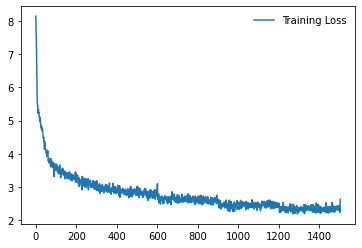

In [29]:
##########################################
# Train the models
##########################################
total_step = len(train_loader)
encoder.train()
decoder.train()
losses = []
for epoch in range(num_epochs):
    for i, (images, captions, lengths, _) in enumerate(train_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        
        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item()))
        # If you want to save the model checkpoints - recommended once you have everything working
        # Make sure to save RNN and LSTM versions separately
        losses.append(loss.item())

    #path_enc = f"/content/gdrive/My Drive/Flickr8k/encoder-{epoch+1}RNN.ckpt"
    #path_dec = f"/content/gdrive/My Drive/Flickr8k/decoder-{epoch+1}RNN.ckpt" 
    #torch.save(decoder.state_dict(), path_dec)
    #torch.save(encoder.state_dict(), path_enc)

print(losses)
plt.plot(losses, label='Training Loss')
plt.legend(frameon=False)
plt.show()